In [3]:
# Importing the modules
from glob import glob
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

### Getting the list of csv

In [4]:
glob('dataset/*.csv')

['dataset\\dengue_features_test.csv',
 'dataset\\dengue_features_train.csv',
 'dataset\\dengue_labels_train.csv']

### Reading the Dataset

In [5]:
dengue_features = pd.read_csv('dataset/dengue_features_train.csv')
dengue_labels = pd.read_csv('dataset/dengue_labels_train.csv')



### Custimizing the plot

In [6]:
plt.style.use('seaborn') # Setting plot style

plt.rcParams['figure.figsize'] = [10, 8] # Setting plot size

### Finding the year that has maximum cases of dengue

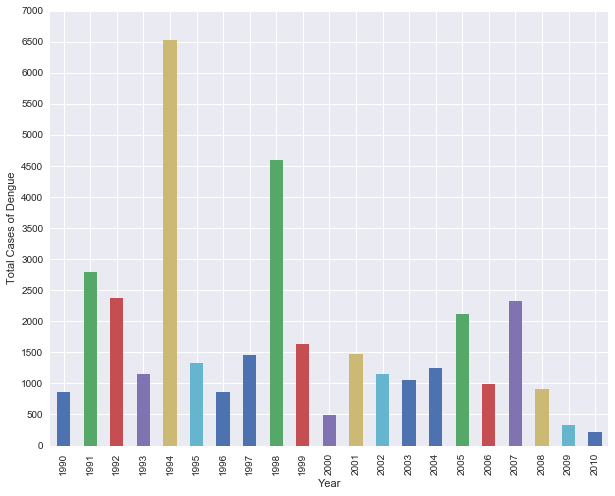

In [7]:
year_max_cases = dengue_labels.groupby(['year'])['total_cases'].agg('sum')

#Visualizing it
year_max_cases.plot(kind='bar')
plt.xlabel('Year')
plt.ylabel('Total Cases of Dengue')
plt.yticks(np.arange(0,7500, step=500))
plt.show()

### City that has maximum cases of dengue

In [8]:
city_affected = dengue_labels.groupby(['city'])['total_cases'].agg('sum')


## Data Preprocessing

In [9]:
# Getting the list of columns having missing values
x = dengue_features.columns[dengue_features.isna().sum() > 0].tolist()


In [10]:
# Filling the missing value with mean
for i in x:
    dengue_features[i] = dengue_features[i].fillna(dengue_features[i].mean())

#### Converting all the temperatures from Kelvin to Centigrade

In [11]:
temperature_kelvin_columns = [i for i in dengue_features.columns if i.find('_temp_k') > -1]


In [12]:
for i in temperature_kelvin_columns:
    dengue_features[i] = dengue_features[i] - 273.15

In [13]:
# Changing the column names from _temp_k to _temp_c
dengue_features.columns = [i.replace('_temp_k', '_temp_c') 
                           for i in dengue_features.columns if i.find('_temp_k')]

### 2. Rounding every value upto 3 decimal places

In [14]:
dengue_features = dengue_features.round(3)



#### Combining station_max_temp_c and station_min_temp_c as `avg_station_max_min`

In [15]:
dengue_features['avg_station_max_min'] = (dengue_features['station_max_temp_c'] + 
                                          dengue_features['station_min_temp_c']) / 2


#### Combining reanalysis_max_air_temp_c and reanalysis_min_air_temp_c as `avg_analysis_max_min`

In [16]:
dengue_features['avg_analysis_max_min'] = (dengue_features['reanalysis_max_air_temp_c'] + 
                                           dengue_features['reanalysis_min_air_temp_c']) / 2



In [17]:
# Adding total cases
dengue_features['total_cases'] = dengue_labels['total_cases']

## Feature Engineering

In [18]:
X_sj = dengue_features[dengue_features['city'] == 'sj']
X_iq = dengue_features[dengue_features['city'] == 'iq']

In [19]:
X_sj = X_sj.drop(['city', 'weekofyear', 'week_start_date'], axis=1)
X_iq = X_iq.drop(['city', 'weekofyear', 'week_start_date'], axis=1)

In [20]:
one_hot_sj = pd.get_dummies(X_sj['year'])
X_sj = X_sj.drop('year', axis=1)
X_sj = X_sj.join(one_hot_sj)

In [21]:
one_hot_iq = pd.get_dummies(X_iq['year'])
X_iq = X_iq.drop('year', axis=1)
X_iq = X_iq.join(one_hot_iq)

In [22]:
years = X_sj.columns[:23:-1].values.tolist()
X_sj = X_sj[years[::-1]].join(X_sj[X_sj.columns[:24]])


In [23]:
years = X_iq.columns[:23:-1].values.tolist()
X_iq = X_iq[years[::-1]].join(X_iq[X_iq.columns[:24]])


In [24]:
# Removing dummy variable trap
X_sj = X_sj.drop(1990, axis=1)
X_iq = X_iq.drop(2000, axis=1)

In [25]:
x_sj_arr = X_sj.iloc[:].values
x_iq_arr = X_iq.iloc[:].values

In [26]:
# np.random.seed(23)
np.random.shuffle(x_sj_arr)
np.random.shuffle(x_iq_arr)

### 5. Splitting the dataframes into train and test

In [27]:
from sklearn.model_selection import train_test_split

X_sj_train, X_sj_test, y_sj_train, y_sj_test = train_test_split(x_sj_arr[:, :-1], x_sj_arr[:, -1], test_size=0.2)
X_iq_train, X_iq_test, y_iq_train, y_iq_test = train_test_split(x_iq_arr[:, :-1], x_iq_arr[:, -1], test_size=0.2)

### 6. Applying Feature Scaling

In [28]:
from sklearn.preprocessing import StandardScaler

sj_scaler = StandardScaler()
X_sj_train = sj_scaler.fit_transform(X_sj_train)
X_sj_test = sj_scaler.transform(X_sj_test)

### Time for modelling

In [29]:
from sklearn.neighbors import KNeighborsRegressor

sj_knn = KNeighborsRegressor(n_neighbors=5)

sj_knn.fit(X_sj_train, y_sj_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform')

In [46]:
y_sj_pred = sj_knn.predict(X_sj_test)


Text(0,0.5,'People expected to get infected')

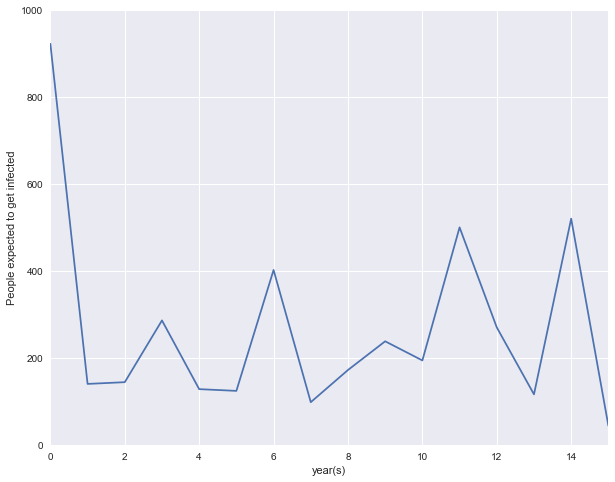

In [49]:
plt.plot(y_sj_pred*10)
plt.xlim(0, 15)
plt.ylim(0, 1000)
plt.xlabel('year(s)')
plt.ylabel('People expected to get infected')
